In [1]:
from __future__ import print_function, division, absolute_import
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.4
# set_session(tf.Session(config=config))
# from clr_callback import CyclicLR
# import dill
from BalancedDannAudioDataGenerator import BalancedAudioDataGenerator
import os,time
from scipy.io import loadmat
import numpy as np
np.random.seed(1)
import math
import pandas as pd
import tables,h5py
from datetime import datetime
import argparse
from keras.utils import plot_model
# from Heartnet import heartnet,getAttentionModel
from collections import Counter
from torchviz import make_dot

Using TensorFlow backend.


In [2]:
# from utils import log_macc, results_log
from dataLoader import reshape_folds
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import matplotlib.pyplot as plt
# import seaborn as sns
# import Evaluator
import dataLoader
# from custom_layers import Attention
from sklearn.model_selection import train_test_split

In [3]:
class wow():
    def __init__(self):
        self.dann = False
        self.self = True
        self.reduce = None
        self.shuffle = 1
        self.mfcc = False
args = wow()

In [4]:
test_domains = 'a'
train_domains = 'dg'
source_domain = train_domains
target_domain = test_domains

test_split = 0
fold_dir = '../../feature/potes_1DCNN/balancedCV/folds/all_folds_wav_name/'

if(args.self):
    print("Self training activated")
    x_train, y_train, y_domain, train_parts, x_val, y_val, val_domain, val_parts,val_wav_files = dataLoader.getData(fold_dir,'',test_domains,0.9,shuffle=args.shuffle)
    print(x_train.shape, x_val.shape)
else:
    x_train, y_train, y_domain, train_parts,x_val, y_val, val_domain, val_parts, val_wav_files = dataLoader.getData(fold_dir,train_domains,test_domains,test_split,shuffle = args.shuffle)

if(args.reduce):
    print("Reduction ", args.reduce)
    x_train,_,y_train,_,y_domain,_ = train_test_split(x_train.transpose(),y_train,y_domain,stratify=y_train,test_size = args.reduce)
    x_train = x_train.transpose()

    #x_val,_,y_val,_,val_domain,_ = train_test_split(x_val.transpose(),y_val,val_domain,stratify=y_val,test_size = args.reduce)
    #x_val = x_val.transpose()

val_files = val_domain
#Create meta labels and domain labels

if(test_split>0):
    source_domain = "".join(set(source_domain).union(set(target_domain)))
    #domains = domains + test_domains

if(args.self):
    print("self training")
    source_domain = test_domains

domains = set(source_domain + target_domain)
#num_class_domain = len(set(train_domains + test_domains))
num_class_domain = len(domains)
num_class = 2

domainClass_source = [(cls,dfc) for cls in range(2) for dfc in source_domain]
domainClass_target = [(cls,dfc) for cls in range(2) for dfc in target_domain]

Self training activated


OSError: Unable to open file (unable to open file: name = '../../feature/potes_1DCNN/balancedCV/folds/all_folds_wav_name/fold_a.mat', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

# Load old fold0_noFIR.mat

In [4]:
import h5py
path = '../../extracted/potes_folds/fold0_noFIR.mat'
data = h5py.File(path, 'r')

In [5]:
list(data.keys())

['trainX',
 'trainY',
 'train_files',
 'train_parts',
 'valX',
 'valY',
 'val_files',
 'val_parts']

In [6]:
x_train = data['trainX'][:].astype('float32')
x_train = np.expand_dims(x_train.transpose(),1)

In [7]:
x_val = data['valX'][:].astype('float32')
x_val = np.expand_dims(x_val.transpose(),1)

In [8]:
y_train = data['trainY'][:].astype('int32')
y_train = y_train.transpose()

In [9]:
y_val = data['valY'][:].astype('int32')
y_val = y_val.transpose()

# mfcc extraction

In [6]:
## Convert to MFCC
import python_speech_features as psf
from matplotlib import cm
if(args.mfcc):
    train_mfcc = np.array([(psf.base.mfcc(x,samplerate=1000,winlen=0.05,winstep=0.01)) for x in x_train.transpose()])
    val_mfcc = np.array([(psf.base.mfcc(x,samplerate=1000,winlen=0.05,winstep=0.01)) for x in x_val.transpose()])
    
    train_mfcc = (train_mfcc-np.mean(train_mfcc))/np.std(train_mfcc)
    val_mfcc = (val_mfcc-np.mean(val_mfcc))/np.std(val_mfcc)
    #train_mfcc = train_mfcc/np.max(np.abs(train_mfcc))
    #val_mfcc = val_mfcc/np.max(np.abs(val_mfcc))
    
    del x_train, x_val
    x_train = train_mfcc.copy()
    x_val = val_mfcc.copy()
    print(x_train.shape, x_val.shape)

In [7]:
meta_labels_source = [domainClass_source.index((cl,df)) for (cl,df) in zip(y_train,y_domain)]
meta_labels_target = None
if(args.dann):
    meta_labels_target = [domainClass_target.index((cl,df)) for (cl,df) in zip((y_val),(val_domain))]
    

domains = "".join(set(source_domain).union(set(target_domain)))

y_domain_source = np.array([list(domains).index(lab) for lab in y_domain])

y_domain_target = np.array([list(domains).index(lab) for lab in val_domain])

################### Reshaping ############

if(args.mfcc):
    [], [y_train,y_domain,y_val] = reshape_folds([],[y_train,y_domain_source,y_val])
else:
    [x_train,x_val], [y_train,y_domain,y_val] = reshape_folds([x_train,x_val],[y_train,y_domain_source,y_val])
y_train = to_categorical(y_train, num_classes=num_class)

print("Y domain ", Counter([x[0] for x in y_domain]))
print("Val domain ", Counter(val_domain))
print("Source Meta labels ", Counter(meta_labels_source))
print("Target Meta labels ", Counter(meta_labels_target))
y_domain_source = to_categorical(y_domain_source,num_classes=num_class_domain)

y_val = to_categorical(y_val, num_classes=num_class)
y_domain_target = to_categorical(y_domain_target,num_classes=num_class_domain)


val_domain = y_domain_target
print("Train files ", y_train.shape, "  Domain ", y_domain.shape)
print("Test files ", y_val.shape, "  Domain ", val_domain.shape)

### Batch Size limmiter 
batch_size = 1000
if(batch_size > max(y_train.shape)):
    print("Batch size if given greater than train files size. limiting batch size")
    batch_size = max(y_train.shape)

reshaped x  (12770, 2500, 1)
reshaped x  (1397, 2500, 1)
reshaped Y  (12770, 1)
reshaped Y  (12770, 1)
reshaped Y  (1397, 1)
Y domain  Counter({0: 12770})
Val domain  Counter({'a': 1397})
Source Meta labels  Counter({1: 8836, 0: 3934})
Target Meta labels  Counter()
Train files  (12770, 2)   Domain  (12770, 1)
Test files  (1397, 2)   Domain  (1397, 1)


In [32]:
x_train.shape,x_val.shape, y_train.shape, y_val.shape, y_domain.shape,val_domain.shape,Counter(meta_labels_source),Counter(meta_labels_target)

NameError: name 'y_domain' is not defined

In [33]:
x_train.shape,x_val.shape

((79810, 1, 2500), (6710, 1, 2500))

In [10]:
######## change 2500 axis for pytorch 
x_train = x_train.transpose((0,2,1))
x_val = x_val.transpose((0,2,1))

In [11]:
batch_size = 1000
datagen_source = BalancedAudioDataGenerator(shift=.1,data_format = 'channels_first')
flow_source = datagen_source.flow(x_train, y_train,
                meta_label=None,
                batch_size=batch_size, shuffle=True,
                seed=1)


Chunk size selected as 500


In [4]:
import torch.optim as optim
import torch
from torch.autograd import Variable
import time
import torch
import torch.nn as nn
# from torchvision import datasets, transforms
from torchsummary import summary
import numpy as np

In [5]:
from mfcc_models import Network

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torchsummary import summary

In [89]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [91]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)

In [92]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [104]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(1, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(9984, num_classes)
        
    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
model = ResNet(ResidualBlock, [2, 2, 2]).to(device)

In [105]:
summary(model.cuda(),(1,2500,64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 2500, 64]             144
       BatchNorm2d-2         [-1, 16, 2500, 64]              32
              ReLU-3         [-1, 16, 2500, 64]               0
            Conv2d-4         [-1, 16, 2500, 64]           2,304
       BatchNorm2d-5         [-1, 16, 2500, 64]              32
              ReLU-6         [-1, 16, 2500, 64]               0
            Conv2d-7         [-1, 16, 2500, 64]           2,304
       BatchNorm2d-8         [-1, 16, 2500, 64]              32
              ReLU-9         [-1, 16, 2500, 64]               0
    ResidualBlock-10         [-1, 16, 2500, 64]               0
           Conv2d-11         [-1, 16, 2500, 64]           2,304
      BatchNorm2d-12         [-1, 16, 2500, 64]              32
             ReLU-13         [-1, 16, 2500, 64]               0
           Conv2d-14         [-1, 16, 2

In [62]:
optimizer = optim.Adam(model.parameters(), lr= .001)
class_criterion = nn.CrossEntropyLoss()
domain_criterion = nn.CrossEntropyLoss()

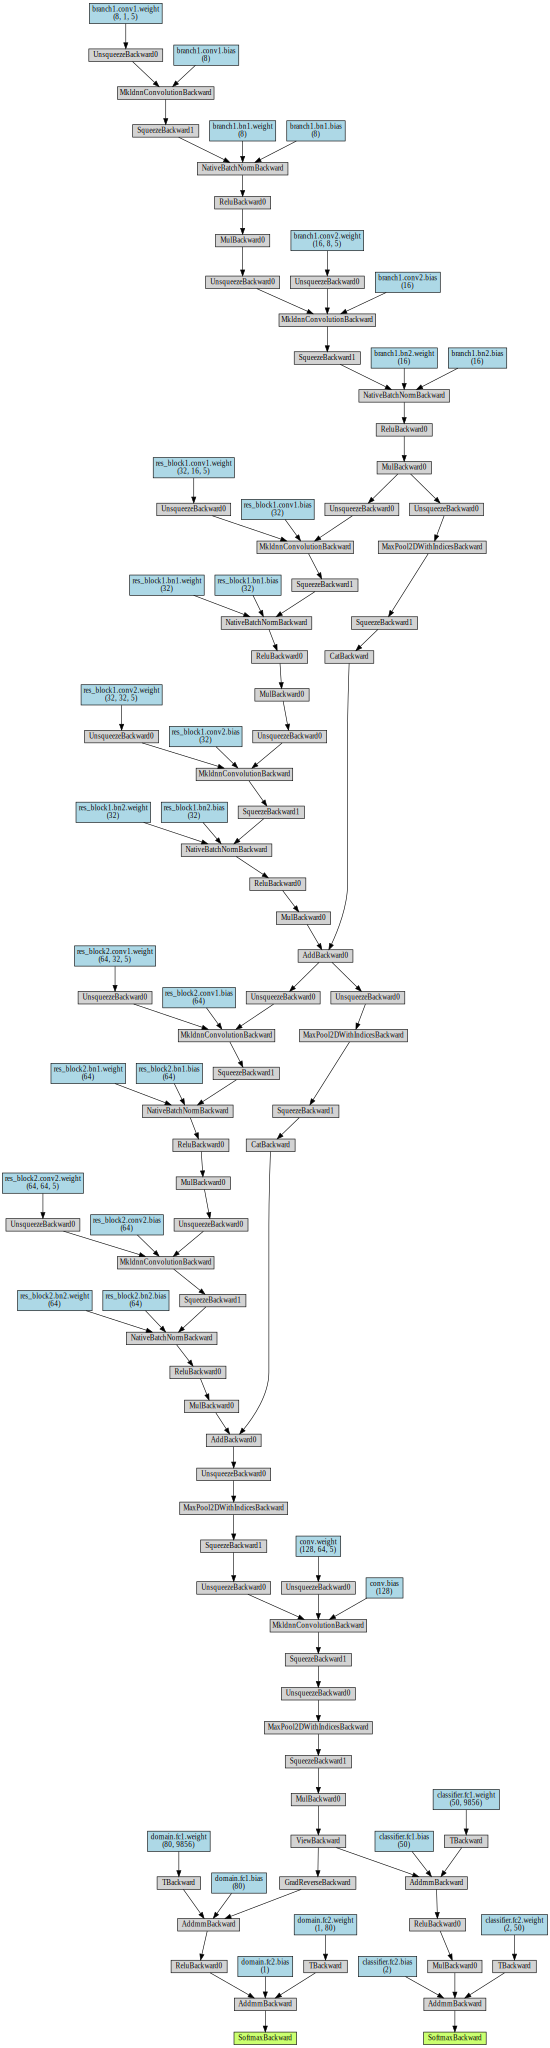

In [16]:
out = model(torch.randn(1,1,2500))

make_dot(out,params = dict(model.named_parameters()))

In [17]:
x_val.shape,y_val.shape,val_domain.shape

((1397, 1, 2500), (1397, 2), (1397, 1))

In [18]:
from sklearn.metrics import confusion_matrix
eps = 0.0000001
def log_macc(y_pred,y_pred_domain, y_val,val_parts):
    y_pred = y_pred.cpu().detach().numpy()
    y_pred_domain = y_pred_domain.cpu().detach().numpy()
    y_val = y_val.cpu().detach().numpy()
    true = []
    pred = []
    files = []
    start_idx = 0

    y_pred = np.argmax(y_pred, axis=-1)
    y_val = np.transpose(np.argmax(y_val, axis=-1))

    for j,s in enumerate(val_parts):

        if not s:  ## for e00032 in validation0 there was no cardiac cycle
            continue
        # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)

        temp_ = y_val[start_idx:start_idx + int(s)]
        temp = y_pred[start_idx:start_idx + int(s)]

        if (sum(temp == 0) > sum(temp == 1)):
            pred.append(0)
        else:
            pred.append(1)

        if (sum(temp_ == 0) > sum(temp_ == 1)):
            true.append(0)
        else:
            true.append(1)

        if val_files is not None:
            files.append(val_files[start_idx])

        start_idx = start_idx + int(s)
    TN, FP, FN, TP = confusion_matrix(true, pred, labels=[0,1]).ravel()
    # TN = float(TN)
    # TP = float(TP)
    # FP = float(FP)
    # FN = float(FN)
    sensitivity = TP / (TP + FN + eps)
    specificity = TN / (TN + FP + eps)
    precision = TP / (TP + FP + eps)
    F1 = 2 * (precision * sensitivity) / (precision + sensitivity + eps)
    Macc = (sensitivity + specificity) / 2
    
    print("TN:",TN,"FP:",FP,"FN:",FN,"TP:",TP)
    print("Sensitivity:","%.2f"%sensitivity,"Specificity:","%.2f"%specificity,"Precision:","%.2f"%precision)
    print("F1:", "%.2f"%F1,"MACC", "%.2f"%Macc)

In [ ]:

model.cuda()
epochs = 400
print("steps ", flow_source.steps_per_epoch)
for e in range(epochs):
    print("EPOCH   ",e+1)
    model.train()
    epoch_loss = 0
    for i in range(flow_source.steps_per_epoch+1):
        
        optimizer.zero_grad()
        
        x,[y,yd] = flow_source.next()
        x,y,yd = torch.from_numpy(x),torch.from_numpy(y),torch.from_numpy(yd)
        x,y,yd = Variable(x),Variable(y),Variable(yd)
        x = x.type(torch.FloatTensor).cuda()
        #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        y = y.long().cuda()
        yd = yd.long().cuda()
        cls, dom = model(x)
        class_loss = class_criterion(cls,torch.argmax(y,axis=1))
        domain_loss_source = domain_criterion(dom,torch.argmax(yd,axis=1))
        
        if(args.dann):
            x,[y,yd] = flow_target.next()
            x,y,yd = torch.from_numpy(x),torch.from_numpy(y),torch.from_numpy(yd)
            x,y,yd = Variable(x),Variable(y),Variable(yd)
            x = x.type(torch.FloatTensor).cuda()
            x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
            y = y.long().cuda()
            yd = yd.long().cuda()
            cls, dom = model(x)
            domain_loss_target = domain_criterion(dom,torch.argmax(yd,axis=1))
            loss = class_loss + domain_loss_source+domain_loss_target
        else:
            loss = class_loss
        epoch_loss = epoch_loss + loss
        
        loss.backward()
        optimizer.step()
    print("Training loss fo", "%.2f"%(epoch_loss.item()/flow_source.steps_per_epoch),end=' ')
    # Validate 
    model.eval()
    with torch.no_grad():
        x,y,yd = torch.from_numpy(x_val),torch.from_numpy(y_val),torch.from_numpy(val_domain)
        x,y,yd = Variable(x),Variable(y),Variable(yd)
        x = x.type(torch.FloatTensor).cuda()
        #x = x.reshape(x.shape[0],1,x.shape[1],x.shape[2])
        y = y.long().cuda()
        yd = yd.long().cuda()
        cls, dom = model(x)
        val_class_loss = class_criterion(cls,torch.argmax(y,axis=1))
        val_domain_loss = domain_criterion(dom,torch.argmax(yd,axis=1))
        print("val_Class_loss  ","%.2f"%val_class_loss.item())
        print("val_dom_loss    ", "%.2f"%val_domain_loss.item())
        log_macc(cls,dom,y,val_parts)
    flow_source.reset()

steps  17
EPOCH    1
Training loss fo 0.64 val_Class_loss   0.58
val_dom_loss     0.00
TN: 0 FP: 12 FN: 0 TP: 31
Sensitivity: 1.00 Specificity: 0.00 Precision: 0.72
F1: 0.84 MACC 0.50
EPOCH    2
Training loss fo 0.63 val_Class_loss   0.57
val_dom_loss     0.00
TN: 0 FP: 12 FN: 1 TP: 30
Sensitivity: 0.97 Specificity: 0.00 Precision: 0.71
F1: 0.82 MACC 0.48
EPOCH    3
Training loss fo 0.62 val_Class_loss   0.56
val_dom_loss     0.00
TN: 1 FP: 11 FN: 1 TP: 30
Sensitivity: 0.97 Specificity: 0.08 Precision: 0.73
F1: 0.83 MACC 0.53
EPOCH    4
Training loss fo 0.62 val_Class_loss   0.55
val_dom_loss     0.00
TN: 3 FP: 9 FN: 3 TP: 28
Sensitivity: 0.90 Specificity: 0.25 Precision: 0.76
F1: 0.82 MACC 0.58
EPOCH    5
Training loss fo 0.61 val_Class_loss   0.55
val_dom_loss     0.00
TN: 5 FP: 7 FN: 3 TP: 28
Sensitivity: 0.90 Specificity: 0.42 Precision: 0.80
F1: 0.85 MACC 0.66
EPOCH    6
Training loss fo 0.61 val_Class_loss   0.55
val_dom_loss     0.00
TN: 5 FP: 7 FN: 4 TP: 27
Sensitivity: 0.87 Sp

Training loss fo 0.53 val_Class_loss   1.05
val_dom_loss     0.00
TN: 12 FP: 0 FN: 31 TP: 0
Sensitivity: 0.00 Specificity: 1.00 Precision: 0.00
F1: 0.00 MACC 0.50
EPOCH    49
Training loss fo 0.53 val_Class_loss   1.04
val_dom_loss     0.00
TN: 12 FP: 0 FN: 31 TP: 0
Sensitivity: 0.00 Specificity: 1.00 Precision: 0.00
F1: 0.00 MACC 0.50
EPOCH    50
Training loss fo 0.52 val_Class_loss   1.04
val_dom_loss     0.00
TN: 12 FP: 0 FN: 31 TP: 0
Sensitivity: 0.00 Specificity: 1.00 Precision: 0.00
F1: 0.00 MACC 0.50
EPOCH    51
Training loss fo 0.52 val_Class_loss   1.04
val_dom_loss     0.00
TN: 12 FP: 0 FN: 31 TP: 0
Sensitivity: 0.00 Specificity: 1.00 Precision: 0.00
F1: 0.00 MACC 0.50
EPOCH    52
Training loss fo 0.53 val_Class_loss   1.05
val_dom_loss     0.00
TN: 12 FP: 0 FN: 31 TP: 0
Sensitivity: 0.00 Specificity: 1.00 Precision: 0.00
F1: 0.00 MACC 0.50
EPOCH    53
Training loss fo 0.52 val_Class_loss   1.05
val_dom_loss     0.00
TN: 12 FP: 0 FN: 31 TP: 0
Sensitivity: 0.00 Specificity: 1.

In [26]:
x_train

array([[[-2.09055126e+00,  2.35563614e+01,  1.99702400e+01, ...,
         -1.16602059e+01, -3.86463749e+00, -5.29322826e+00],
        [-1.53748467e+00,  2.09180603e+01,  2.28279073e+01, ...,
         -1.21367998e+01, -6.80110962e+00, -5.35970520e+00],
        [-1.48575541e+00,  2.52203408e+01,  1.30287019e+01, ...,
         -6.53360070e+00, -1.55807942e+01, -9.70069363e+00],
        ...,
        [-3.60436534e+01,  0.00000000e+00, -3.20763172e-14, ...,
         -3.27769755e-13,  0.00000000e+00,  3.59484803e-13],
        [-3.60436534e+01,  0.00000000e+00, -3.20763172e-14, ...,
         -3.27769755e-13,  0.00000000e+00,  3.59484803e-13],
        [-3.60436534e+01,  0.00000000e+00, -3.20763172e-14, ...,
         -3.27769755e-13,  0.00000000e+00,  3.59484803e-13]],

       [[-2.09074119e+00,  2.06450686e+01,  2.11223066e+01, ...,
         -7.59913915e+00, -1.51967320e+00, -5.64122031e+00],
        [-1.98125237e+00,  3.15186120e+01,  1.70842986e+01, ...,
         -1.48560845e+01, -5.46420531e

In [23]:
np.mean(x_train),np.std(x_train),np.max(x_train), np.min(x_train)

(-2.6550720271704655,
 10.366587960136307,
 62.03362225629224,
 -62.88979758397365)

In [28]:
x_trainn = (x_train-np.mean(x_train))/np.std(x_train)

In [29]:
np.mean(x_trainn),np.std(x_trainn),np.max(x_trainn), np.min(x_trainn)

(-2.942546546239869e-17,
 0.9999999999999999,
 6.240114349313073,
 -5.810467801790703)

In [5]:
from mfcc_models import Smallnet

In [6]:
net = Smallnet(2,5)

In [8]:
summary(net.cuda(),(1,2500))

torch.Size([2, 1, 2500])
torch.Size([2, 9856])
domain torch.Size([2, 9856])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1              [-1, 8, 2496]              48
       BatchNorm1d-2              [-1, 8, 2496]              16
              ReLU-3              [-1, 8, 2496]               0
           Dropout-4              [-1, 8, 2496]               0
            Conv1d-5             [-1, 16, 2492]             656
       BatchNorm1d-6             [-1, 16, 2492]              32
              ReLU-7             [-1, 16, 2492]               0
           Dropout-8             [-1, 16, 2492]               0
            Branch-9             [-1, 16, 2492]               0
           Conv1d-10             [-1, 32, 1246]           2,592
      BatchNorm1d-11             [-1, 32, 1246]              64
             ReLU-12             [-1, 32, 1246]               0
          Dropout-13       

In [20]:
num_filt = (8, 4)
num_dense = 20
lr = 0.01
bn_momentum = 0.99
eps = 1.1e-5
bias = False
l2_reg = 0.04864911065093751
l2_reg_dense = 0.
kernel_size = 5
maxnorm = 10000.
dropout_rate = 0.5
dropout_rate_dense = 0.
padding = 'valid'
activation_function = 'relu'
subsam = 2
FIR_train= True
trainable = True
hp_lambda = np.float32(0)
lr_decay =0.0001132885
random_seed = 1
num_class =2
num_class_domain = num_class_domain
tipe= 1
decision = 'majority' 
channels = '0101'

array([ 73,  22,  71,  54,  57,  14,  34, 134,  47,  31,  21,  60,  69,
        41, 120,  66,  93, 110, 142,  69,  86,  81, 105,  35,  17,  91,
        38], dtype=int32)

In [17]:
loadpath='../../Adversarial Heart Sound Results/models/bcdefghi_a 2019-10-16 12:45:03.236037/weights.0036-0.5964.hdf5'
loadatttrain = '../../Adversarial Heart Sound Results/models/attention/bcdefghi_a 2019-10-20 12:37:52.424551/weights.0010-0.5444.hdf5'
loadpath = None

In [6]:
model = heartnet(loadpath,activation_function, bn_momentum, bias, dropout_rate, dropout_rate_dense,
                             eps, kernel_size, l2_reg, l2_reg_dense, lr, lr_decay, maxnorm,
                             padding, random_seed, subsam, num_filt, num_dense, FIR_train, trainable, tipe,
                             num_class=num_class,num_class_domain=9,hp_lambda=hp_lambda,segments=channels)

Instructions for updating:
Colocations handled automatically by placer.


In [7]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 2900, 1)      0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 200, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 800, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 200, 1)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_4 (

In [32]:
len("conv1d_linearphase_type_5")

25

In [15]:
model.fit_generator(flow,#steps_per_epoch=len(x_train) // batch_size,
                    steps_per_epoch=flow.steps_per_epoch,
                    # max_queue_size=20,
                    use_multiprocessing=False,
                    epochs=200,
                    verbose=1,
                    shuffle=True,
                    callbacks=[log_macc(val_parts, decision=decision,verbose=1,val_files=val_files,wav_files=val_wav_files,checkpoint_name = 'ansari')],
                    validation_data=(x_val, [y_val,val_domain]),
                    initial_epoch=0,
                    )

Check point  ansari
Instructions for updating:
Use tf.cast instead.
Epoch 1/200


ResourceExhaustedError: OOM when allocating tensor of shape [9952,20] and type float
	 [[node training/SGD/zeros_1 (defined at /home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:702) ]]

Caused by op 'training/SGD/zeros_1', defined at:
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 563, in start
    self.io_loop.start()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/asyncio/base_events.py", line 534, in run_forever
    self._run_once()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/asyncio/base_events.py", line 1771, in _run_once
    handle._run()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/ioloop.py", line 743, in _run_callback
    ret = callback()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/gen.py", line 787, in inner
    self.run()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/gen.py", line 748, in run
    yielded = self.gen.send(value)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 365, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 272, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 542, in execute_request
    user_expressions, allow_stdin,
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tornado/gen.py", line 209, in wrapper
    yielded = next(result)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2855, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2881, in _run_cell
    return runner(coro)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 68, in _pseudo_sync_runner
    coro.send(None)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3058, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3249, in run_ast_nodes
    if (await self.run_code(code, result,  async_=asy)):
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3326, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-15-1ce4ce239100>", line 10, in <module>
    initial_epoch=0,
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training.py", line 1418, in fit_generator
    initial_epoch=initial_epoch)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training_generator.py", line 40, in fit_generator
    model._make_train_function()
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/engine/training.py", line 509, in _make_train_function
    loss=self.total_loss)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/legacy/interfaces.py", line 91, in wrapper
    return func(*args, **kwargs)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/optimizers.py", line 193, in get_updates
    moments = [K.zeros(shape) for shape in shapes]
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/optimizers.py", line 193, in <listcomp>
    moments = [K.zeros(shape) for shape in shapes]
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py", line 702, in zeros
    v = tf.zeros(shape=shape, dtype=tf_dtype, name=name)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 1817, in zeros
    output = fill(shape, constant(zero, dtype=dtype), name=name)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 3367, in fill
    "Fill", dims=dims, value=value, name=name)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3300, in create_op
    op_def=op_def)
  File "/home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor of shape [9952,20] and type float
	 [[node training/SGD/zeros_1 (defined at /home/mhealthra2/anaconda3/envs/tensor/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:702) ]]


In [37]:
wow = model.get_layer('att').get_weights()[0]

In [14]:
wow

NameError: name 'wow' is not defined

In [43]:
domainClass = [(cls,dfc) for cls in range(2) for dfc in train_domain]
meta_label = [hey.index((cl,df)) for (cl,df) in zip(y,yd)]

In [44]:
model_json = model.to_json()

TypeError: can't pickle _thread.RLock objects

In [21]:
list(set('sdff'+'cdc'))

['f', 's', 'c', 'd']

In [166]:
[e%50>39 for e in range(60)]

[False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False]

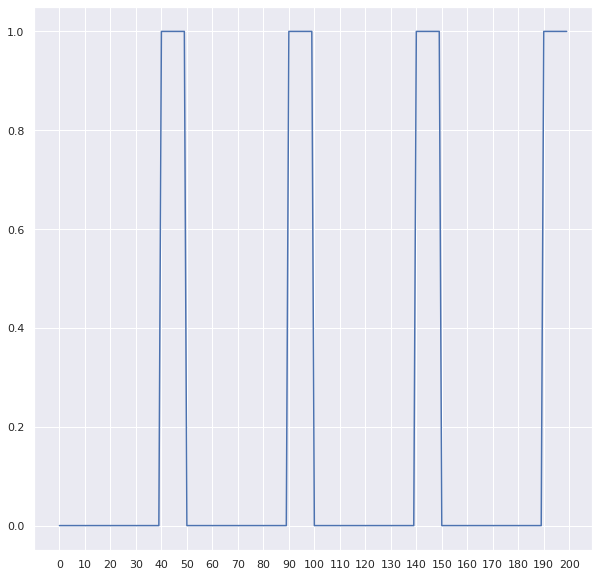

In [165]:
plt.figure(figsize=(10,10))
plt.xticks([10*x for x in range(21)])
plt.plot([e%50>39 for e in range(200)])

In [30]:
import matplotlib.pyplot as plt
import numpy as np , math

In [65]:
hp_lambda = 0.01
epochs = 400
def sig_moid(epoch):
    minEpoch = 150
    if(False):#args.fixed):
        return hp_lambda
    if hp_lambda == 0:
        return hp_lambda
    #     if epoch<minEpoch:
    #         return np.float32(0.0)
    maxx =  8
    p = 3*(epoch-(epochs/2)) / (epochs/2)
    lam = 8/(1+math.e**(-p))
    lam = lam#*(epoch%50<10)
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return lam
def f_hp_anneal(epoch):
    minEpoch = 150
    if(False):#args.fixed):
        return hp_lambda
    if hp_lambda == 0:
        return hp_lambda
    #     if epoch<minEpoch:
    #         return np.float32(0.0)
    gamma =  4
    p = (epoch) / (epochs)
    lam =  (8 / (2 + 3*(math.e ** (- gamma * p)))) - 1+hp_lambda  # 3 porjonto jaabe
    lam = lam#*(epoch%50<10)
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return lam
def sin_up(epoch):
    minEpoch = 150
    if(False):#args.fixed):
        return hp_lambda
    if hp_lambda == 0:
        return hp_lambda
    #     if epoch<minEpoch:
    #         return np.float32(0.0)
    maxx =  4
    p = (epoch) / (epochs)
    lam = (1+math.sin(p*(math.pi)+1.5*math.pi))*maxx+hp_lambda
    lam = lam#*(epoch%50<10)
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return lam
def f_hp_decay(epoch):
    minEpoch = 150
    if hp_lambda == 0:
        return hp_lambda
    if epoch<minEpoch:
        return np.float32(0.0)
    gamma =  4

    p = (epoch-minEpoch) / (epochs)
    lam =  (10 /2* (1 + 1*(math.e ** (- gamma * p)))) - 1+hp_lambda  # 3 porjonto jaabe
    # hp_lambda = hp_lambda * (params['hp_decay_const'] ** global_epoch_counter)
    return np.float32(lam)

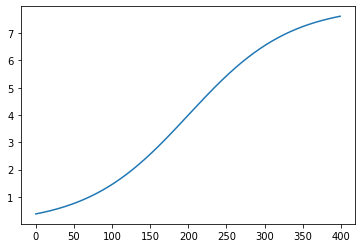

In [66]:
plt.plot([sig_moid(e) for e in range(epochs)])

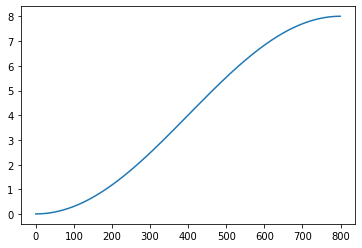

In [51]:
plt.plot([sin_up(e) for e in range(epochs)])

In [23]:
[f_hp_anneal(e) for e in range(epochs)]

[0.6000010000000001,
 0.6096105294501716,
 0.619238834411952,
 0.6288854871574298,
 0.6385500564888148,
 0.6482321078102388,
 0.6579312032008996,
 0.6676469014895251,
 0.6773787583301291,
 0.6871263262790376,
 0.6968891548731556,
 0.7066667907094507,
 0.7164587775256214,
 0.7262646562819269,
 0.736083965244141,
 0.745916240067609,
 0.7557610138823675,
 0.7656178173793012,
 0.7754861788973036,
 0.7853656245114021,
 0.7952556781218237,
 0.8051558615439588,
 0.8150656945991887,
 0.8249846952065453,
 0.8349123794751615,
 0.8448482617974792,
 0.8547918549431722,
 0.8647426701537534,
 0.8747002172378201,
 0.8846640046669053,
 0.8946335396718849,
 0.9046083283399179,
 0.9145878757118601,
 0.9245716858801255,
 0.9345592620869488,
 0.9445501068230023,
 0.9545437219263387,
 0.9645396086816059,
 0.9745372679194987,
 0.9845362001164005,
 0.994535905494179,
 1.0045358841200882,
 1.0145356360067364,
 1.024534661212076,
 1.034532459939377,
 1.0445285326371365,
 1.0545223800988837,
 1.0645135035628408

In [2]:
def step_decay(epoch):         
    lr0 = .00128437
    #print("learning rate , lr 0 ", lr, lr0)
    a = 1
    b = 1
    p = epoch/epochs
    lrate = lr0/math.pow((1+a*p),b)
    return lrate

In [3]:
epochs = 200

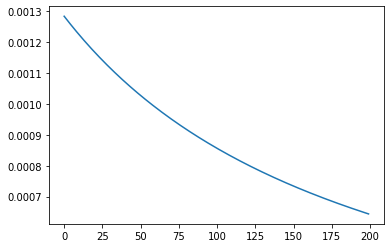

In [4]:
plt.plot([step_decay(e) for e in range(epochs)])

In [96]:
from __future__ import print_function, absolute_import, division
from keras import backend as K
from keras.engine.topology import Layer
from keras.engine.topology import InputSpec
import tensorflow as tf
from keras.utils import conv_utils
from keras.layers import activations, initializers, regularizers, constraints
import numpy as np
from scipy.fftpack import dct
from keras.backend.common import normalize_data_format
from keras.layers.merge import Multiply
class Attt(Layer):
    '''Custom Layer for ResNet used for BatchNormalization.

    Linear learnable weight vector , does dot multiplication on a vector
    # Arguments
        axis: integer, axis along which to normalize in mode 0. For instance,
            if your input tensor has shape (samples, channels, rows, cols),
            set axis to 1 to normalize per feature map (channels axis).'''

    def __init__(self, weights=None, axis=-1,init='he_normal',**kwargs):
        self.axis = axis
        self.init = initializers.get(init)
        self.kernel = weights
        super(Attt, self).__init__(**kwargs)
    def build(self, input_shape):
        if len(input_shape)>2:
            raise ValueError("Input to attention layer hasn't been flattened")
        self.input_dim = input_shape[-1]            
        self.kernel = self.add_weight(shape=(self.input_dim,),
                                      initializer=initializers.Ones(),
                                      name='kernel',
                                      constraint=constraints.NonNeg()
                                      #constraint=constraints.min_max_norm(min_value=0.0, max_value=1.0)
                                      #constraint=constraints.UnitNorm(axis=self.axis)
                                     )
        self.input_spec = InputSpec(min_ndim=2, axes={-1: self.input_dim})            
        self.built = True
    def call(self, inputs):
        output = tf.multiply(inputs,self.kernel)
        return output
    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = {
            'axis': self.axis,
            'kernel_initializer': initializers.serialize(self.init)
        }
        base_config = super(Attt, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [98]:
from keras.layers import Input, Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Activation, AveragePooling1D

In [6]:
for i in range(4):
    print('outer',i)
    for j in range(3):
        print('        innter',j)
        if(j==1):
            return

SyntaxError: 'return' outside function (<ipython-input-6-fc117c48f735>, line 6)